In [1]:
from readresults.readres_univar import get_contrast_files
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
import pandas as pd
from nilearn import plotting, surface, datasets
from nilearn.reporting import get_clusters_table
from nilearn.image import new_img_like
import nibabel as nb
import numpy as np
from glob import glob
import pingouin as pg

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):
/home/predatt/giaald/nipype/nipype/utils/misc.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterator
/home/predatt/giaald/nipype/nipype/interfaces/base/traits_extension.py:22: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Second-level analysis

In [8]:
subjlist = [f'sub-{i:03d}' for i in range(1, 36) if i not in [6]]#[1, 6, 12, 18, 28]]
design_matrix = pd.DataFrame([1] * len(subjlist), columns=['intercept'])
contrfiles = get_contrast_files(subjlist, 'test', 5, 1)

In [9]:
second_level_model = SecondLevelModel().fit(
    contrfiles, design_matrix=design_matrix
)

In [10]:
z_map = second_level_model.compute_contrast(second_level_stat_type='t', output_type="z_score")

In [11]:
thresholded_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.001,
    height_control="fpr",
    cluster_threshold=10,
    two_sided=True,
)
thresholded_map = new_img_like(thresholded_map, np.nan_to_num(thresholded_map.get_fdata()))

In [12]:
get_clusters_table(z_map, threshold, cluster_threshold=10,
                   two_sided=True)

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-6.0,-68.0,56.0,4.947572,616
1,1a,-10.0,-62.0,52.0,4.318722,
2,1b,-6.0,-68.0,62.0,3.822460,
3,1c,-14.0,-64.0,54.0,3.506159,
4,2,36.0,-72.0,42.0,4.721338,1104
5,2a,34.0,-58.0,42.0,4.064059,
6,2b,34.0,-56.0,50.0,4.047959,
7,2c,40.0,-64.0,40.0,3.961346,
8,3,-24.0,-66.0,44.0,4.690061,616
9,4,8.0,-70.0,54.0,4.606001,656


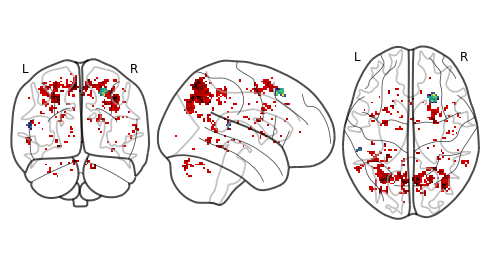

In [13]:
disp = plotting.plot_glass_brain(z_map, threshold=threshold, draw_cross=False)
disp.add_overlay('results_plots/univar_maps/infocoupling_neg.nii')

In [6]:
get_clusters_table(z_map, threshold, cluster_threshold=10,
                   two_sided=True)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/reporting/_get_clusters_table.py:339: UserWarning: Attention: No clusters with stat lower than -3.2905267314918945
  warnings.warn(


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,8.0,-70.0,54.0,4.874613,272
1,2,36.0,-72.0,42.0,4.840486,312
2,3,-6.0,-68.0,56.0,4.704858,320
3,3a,-10.0,-62.0,52.0,4.316959,
4,4,-24.0,-66.0,44.0,4.335372,408
5,5,-32.0,-78.0,38.0,4.259166,104
6,6,26.0,-4.0,50.0,4.100108,104
7,7,22.0,-68.0,56.0,4.022948,168
8,8,-26.0,8.0,58.0,3.911024,88
9,9,-34.0,-54.0,46.0,3.902468,96


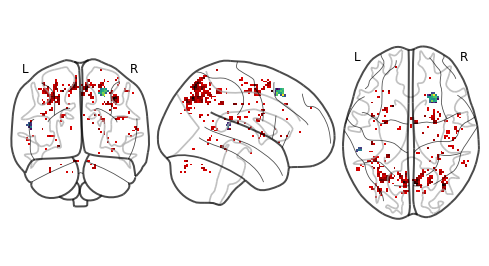

In [7]:
disp = plotting.plot_glass_brain(z_map, threshold=threshold, draw_cross=False)
disp.add_overlay('results_plots/univar_maps/infocoupling_neg.nii')

In [35]:
nb.save(thresholded_map, 'results_plots/univar_maps/incongr_vs_congr.nii')

### Surface plot

In [27]:
fsaverage = datasets.fetch_surf_fsaverage()
texture = surface.vol_to_surf(thresholded_map, fsaverage.infl_right)
curv_right = surface.load_surf_data(fsaverage.curv_right)
curv_right_sign = np.sign(curv_right)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


In [35]:
from nilearn import datasets

stat_img = nb.load(datasets.load_sample_motor_activation_image())

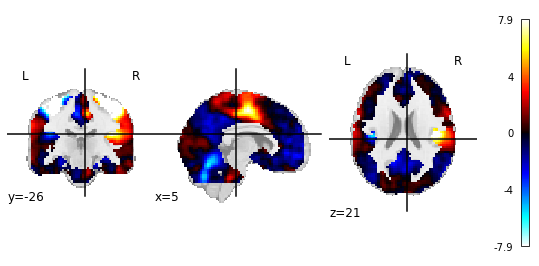

In [39]:
plotting.plot_stat_map(stat_img)

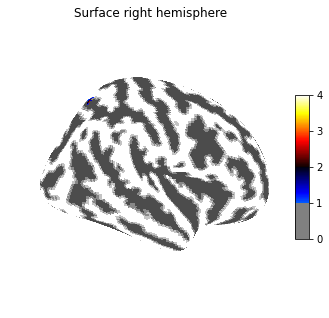

In [28]:
fig = plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture, hemi='right',
    title='Surface right hemisphere', colorbar=True,
    threshold=1., bg_map=curv_right_sign,
)
fig.show()

## ROI analysis

In [41]:
allfiles = glob('../../Univar_results/test_m5/*.csv')
allfiles = [f for f in allfiles if 'sub-006' not in f]

In [42]:
allfiles

['../../Univar_results/test_m5/sub-023_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-012_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-014_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-017_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-028_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-015_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-031_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-004_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-020_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-011_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-034_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-033_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-010_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-013_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-002_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-009_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-003_ba-19-37.csv',
 '../../Univar_results/test_m5/sub-007_ba-19-37.csv',
 '../../Univar_results/test_

In [43]:
len(allfiles)

68

In [45]:
univar_df = []
for f in allfiles:
    thisdf = pd.read_csv(f)
    thisdf['roi'] = 'ba-17-18' if 'ba-17-18' in f else 'ba-19-37'
    univar_df.append(thisdf)
univar_df = pd.concat(univar_df)

In [47]:
univar_df.roi.unique()

array(['ba-19-37', 'ba-17-18'], dtype=object)

In [48]:
univar_df = univar_df.groupby(['condition', 'roi', 'subject']).mean().reset_index()

In [51]:
univar_df.groupby(['roi', 'condition'])['mean_beta'].agg(['mean', 'sem'])

mean       sem
roi      condition                     
ba-17-18 expected   -1.924122  0.292792
         unexpected -1.847878  0.311420
ba-19-37 expected   -0.630116  0.220054
         unexpected -0.541722  0.225718

In [53]:
univar_1718 = univar_df[univar_df['roi']=='ba-17-18']
univar_1937 = univar_df[univar_df['roi']=='ba-19-37']

In [54]:
pg.ttest(univar_1718[univar_1718['condition']=='expected'].mean_beta,
         univar_1718[univar_1718['condition']=='unexpected'].mean_beta,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.034888,33,two-sided,0.308246,"[-0.23, 0.07]",0.043261,0.301,0.056904


In [55]:
pg.ttest(univar_1937[univar_1937['condition']=='expected'].mean_beta,
         univar_1937[univar_1937['condition']=='unexpected'].mean_beta,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.30722,33,two-sided,0.200174,"[-0.23, 0.05]",0.068009,0.4,0.06716
